In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import re
import tqdm
import os
from collections import defaultdict

In [24]:
model_map = {'google_gemma-2-2b': 'Gemma-2-2B', 'google_gemma-2-2b-it': 'Gemma-2B-Instruct', 'microsoft_phi-2': 'Phi-2', 'meta-llama_Llama-3.1-8B': 'Llama3.1-8B', 'meta-llama_Llama-3.1-8B-Instruct': 'Llama3.1-8B-Instruct', 'microsoft_Phi-3.5-mini-instruct': 'Phi-3.5-mini-Instruct', 'allenai_OLMoE-1B-7B-0924': 'OLMoE-1B-7B-0924', 'mistralai_Mistral-7B-v0.3': 'Mistral-7B', 'mistralai_Mistral-7B-Instruct-v0.3': 'Mistral-7B-Instruct', 'allenai_OLMoE-1B-7B-0924-Instruct': 'OLMoE-1B-7B-0924-Instruct'}

model_color_map = {
    'google_gemma-2-2b': 'tab:blue',
    'google_gemma-2-2b-it': 'tab:orange',
    'microsoft_phi-2': 'tab:green',
    'meta-llama_Llama-3.1-8B': 'tab:red',
    'meta-llama_Llama-3.1-8B-Instruct': 'tab:purple',
    'microsoft_Phi-3.5-mini-instruct': 'tab:cyan',
    'allenai_OLMoE-1B-7B-0924': 'tab:pink',
    'mistralai_Mistral-7B-v0.3': 'tab:gray',
    'mistralai_Mistral-7B-Instruct-v0.3': 'tab:olive'
}

In [3]:
plt.rcParams.update({
    'figure.figsize': (6, 4),            # Figure size
    'figure.dpi': 100,                   # High DPI for publication-quality images
    'axes.titlesize': 14,                # Title font size
    'axes.labelsize': 12,                # Axis label font size
    'axes.labelpad': 10,                 # Padding for labels
    'axes.linewidth': 1,                 # Axis line width
    'axes.grid': False,                  # Disable grid unless necessary
    'xtick.labelsize': 10,               # X-axis tick label size
    'ytick.labelsize': 10,               # Y-axis tick label size
    'xtick.major.size': 4,               # Length of major ticks
    'ytick.major.size': 4,               # Length of major ticks
    'xtick.major.width': 1,              # Width of major ticks
    'ytick.major.width': 1,              # Width of major ticks
    'xtick.direction': 'in',             # Ticks facing inwards
    'ytick.direction': 'in',             # Ticks facing inwards
    'legend.fontsize': 10,               # Legend font size
    'legend.frameon': True,             # Disable legend frame for a cleaner look
    'font.family': 'serif',              # Use a serif font for text
    'font.serif': ['DejaVu Serif'],      # Use 'DejaVu Serif' as the fallback serif font
    'lines.linewidth': 1.5,              # Line width for plots
    'lines.markersize': 6,               # Marker size
    'savefig.dpi': 300,                  # Save figure resolution
    'savefig.bbox': 'tight',             # Adjust layout to avoid clipping
})

In [4]:
# Load the stats data from the folder
model_keys = [
    '/home/davidchan/Repos/random_needles/exps/contextual/die_roll/allenai_OLMoE-1B-7B-0924',
    '/home/davidchan/Repos/random_needles/exps/contextual/die_roll/allenai_OLMoE-1B-7B-0924-Instruct'
    '/home/davidchan/Repos/random_needles/exps/contextual/die_roll/google_gemma-2-2b',
    '/home/davidchan/Repos/random_needles/exps/contextual/die_roll/google_gemma-2-2b-it',
    '/home/davidchan/Repos/random_needles/exps/contextual/die_roll/google_gemma-2b',
    '/home/davidchan/Repos/random_needles/exps/contextual/die_roll/keeeeenw_MicroLlama',
    '/home/davidchan/Repos/random_needles/exps/contextual/die_roll/meta-llama_Llama-3.1-8B',
    '/home/davidchan/Repos/random_needles/exps/contextual/die_roll/meta-llama_Llama-3.1-8B-Instruct',
    '/home/davidchan/Repos/random_needles/exps/contextual/die_roll/meta-llama_Llama-3.1-70B',
    '/home/davidchan/Repos/random_needles/exps/contextual/die_roll/microsoft_phi-2',
    '/home/davidchan/Repos/random_needles/exps/contextual/die_roll/microsoft_Phi-3.5-mini-instruct',
    '/home/davidchan/Repos/random_needles/exps/contextual/die_roll/mistralai_Mistral-7B-Instruct-v0.3',
    '/home/davidchan/Repos/random_needles/exps/contextual/die_roll/mistralai_Mistral-7B-v0.3',
]

model_stats_data = {}
for key in tqdm.tqdm(model_keys):
    if os.path.exists(f'{key}/stats.pkl'):
        with open(f'{key}/stats.pkl', 'rb') as f:
            model_stats_data[key.split('/')[-1]] = pickle.load(f)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 49.64it/s]


In [8]:
print(model_stats_data['allenai_OLMoE-1B-7B-0924']['biased_point'].keys())

dict_keys(['When I roll dice they land on 1 60% of the time.', 'When I roll dice they land on 1 80% of the time.', 'When I roll dice they land on 2 60% of the time.', 'When I roll dice they land on 2 80% of the time.', 'When I roll dice they land on 3 60% of the time.', 'When I roll dice they land on 3 80% of the time.', 'When I roll dice they land on 4 60% of the time.', 'When I roll dice they land on 4 80% of the time.', 'When I roll dice they land on 5 60% of the time.', 'When I roll dice they land on 5 80% of the time.', 'When I roll dice they land on 6 60% of the time.', 'When I roll dice they land on 6 80% of the time.'])


In [5]:
def tvd(p, q):
    return 0.5 * np.sum(np.abs(p - q))

In [6]:
key_data = {}
for key, stats in model_stats_data.items():
    key_data[key] = defaultdict(list)
    if 'biased_point' not in stats:
        continue
    for k, v in stats['biased_point'].items():
        # Matches the bias percent
        percent = int(re.search(r"(\d+(\.\d+)?)%", k).group(1))
        # Matches the head (land on X Y% of the time) (matches X)
        head = int(re.search(r"land on (\d+)", k).group(1))

        key_data[key][head].append((percent, tvd(v['choice_probs'], np.exp(v["expected_dist"]))))
    for head in key_data[key]:
        key_data[key][head] = sorted(key_data[key][head], key=lambda x: x[0])

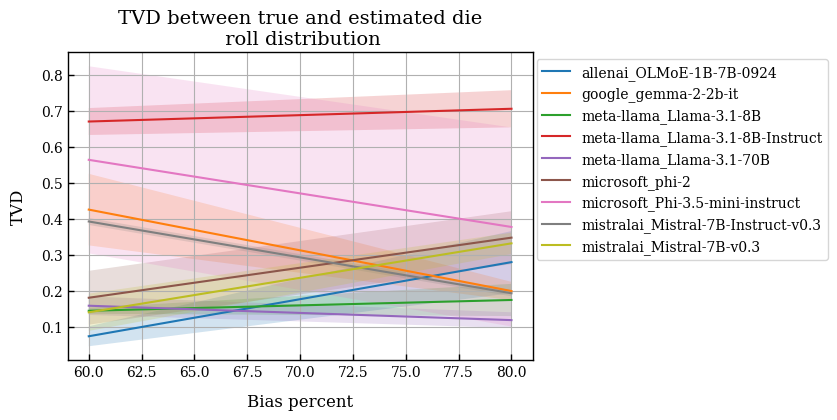

In [7]:
plt.clf()

# For each model, plot the mean and standard deviation of the TVD
for key, data in key_data.items():
    mean = np.mean([np.array(data[head])[:, 1] for head in data], axis=0)
    std = np.std([np.array(data[head])[:, 1] for head in data], axis=0)
    plt.plot(np.array(data[1])[:, 0], mean, label=key)
    plt.fill_between(np.array(data[1])[:, 0], mean - std, mean + std, alpha=0.2)

plt.xlabel('Bias percent')
plt.ylabel('TVD')
plt.legend(bbox_to_anchor=(1.65, 1))
plt.grid()
plt.title('TVD between true and estimated die\n roll distribution')
plt.show()

In [12]:
# Plot all models
import glob
import itertools
root_dir = '../exps/contextual/die_roll_multiset_v2'

# Discover all folders in the root directory
folders = glob.glob(f'{root_dir}/*')

print(folders)

# Extract model names
model_names = [folder.split('/')[-1] for folder in folders]

# Load all stats
data = defaultdict(list)
model_stats_data = {}
for model_name in model_names:
    stats_file = f'{root_dir}/{model_name}/stats.pkl'
    print(stats_file)
    if not os.path.exists(stats_file):
        continue
    with open(stats_file, 'rb') as f:
        model_stats_data[model_name] = pickle.load(f)
    model_is_instruct = 'it' in model_name.lower() or 'instruct' in model_name.lower()
    for bias in (0 , 20, 40, 60, 80, 100):
        die_sides = []
        for key in model_stats_data[model_name]['averaged_stats']['biased_point']:
            if f'{bias}%' not in key:
                continue

            die_sides.append((
                model_stats_data[model_name]['averaged_stats']['biased_point'][key]['tvd']['mean'],
                model_stats_data[model_name]['averaged_stats']['biased_point'][key]['tvd']['std']
            ))

        # Take the mean of the die sides
        mean = np.nanmean([side[0] for side in die_sides])
        # Take the nanmean of the standard deviation
        std = np.nanmean([side[1] for side in die_sides])
        data[model_name].append((bias,model_is_instruct, mean, std, ))

['../exps/contextual/die_roll_multiset_v2/microsoft_Phi-3.5-mini-instruct', '../exps/contextual/die_roll_multiset_v2/mistralai_Mistral-7B-v0.3', '../exps/contextual/die_roll_multiset_v2/mistralai_Mistral-7B-Instruct-v0.3', '../exps/contextual/die_roll_multiset_v2/allenai_OLMoE-1B-7B-0924-Instruct', '../exps/contextual/die_roll_multiset_v2/meta-llama_Llama-3.1-8B-Instruct', '../exps/contextual/die_roll_multiset_v2/google_gemma-2-2b', '../exps/contextual/die_roll_multiset_v2/meta-llama_Llama-3.1-8B', '../exps/contextual/die_roll_multiset_v2/microsoft_phi-2', '../exps/contextual/die_roll_multiset_v2/google_gemma-2-2b-it', '../exps/contextual/die_roll_multiset_v2/allenai_OLMoE-1B-7B-0924']
../exps/contextual/die_roll_multiset_v2/microsoft_Phi-3.5-mini-instruct/stats.pkl
../exps/contextual/die_roll_multiset_v2/mistralai_Mistral-7B-v0.3/stats.pkl
../exps/contextual/die_roll_multiset_v2/mistralai_Mistral-7B-Instruct-v0.3/stats.pkl
../exps/contextual/die_roll_multiset_v2/allenai_OLMoE-1B-7B-09

In [20]:
del data['allenai_OLMoE-1B-7B-0924-Instruct']
print(data['microsoft_Phi-3.5-mini-instruct'][0])

(0, True, 0.7028113688585368, 0.2205364957860031)


<Figure size 600x400 with 0 Axes>

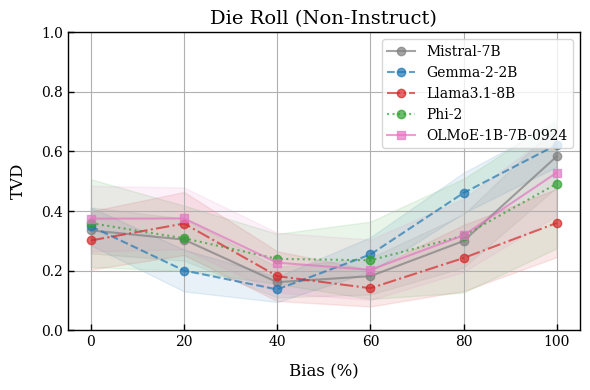

In [21]:
# Plot non-instruct models
plt.clf()
plt.figure()
linestyles = itertools.cycle(['-o', '--o', '-.o', ':o', '-s', '--s', '-.s', ':s', '-^', '--^', '-.^', ':^'])
for i, (model_name, values) in enumerate(data.items()):
    if not values[0][1]:
        color = plt.cm.tab10(i)
        if 'MicroLlama' in model_name:
            continue
        plt.plot([x[0] for x in values], [x[2] for x in values], next(linestyles), label=model_map[model_name],  alpha=0.7, color=model_color_map[model_name])
        plt.fill_between([x[0] for x in values], [x[2] - x[3] for x in values], [x[2] + x[3] for x in values], alpha=0.1, color=model_color_map[model_name])

plt.grid()
plt.title('Die Roll (Non-Instruct)')
plt.xlabel('Bias (%)')
plt.ylabel('TVD')
plt.ylim(0,1)
plt.tight_layout()
plt.legend(loc='upper right')
plt.savefig('die_roll_non_instruct.pdf', bbox_inches='tight')


<Figure size 600x400 with 0 Axes>

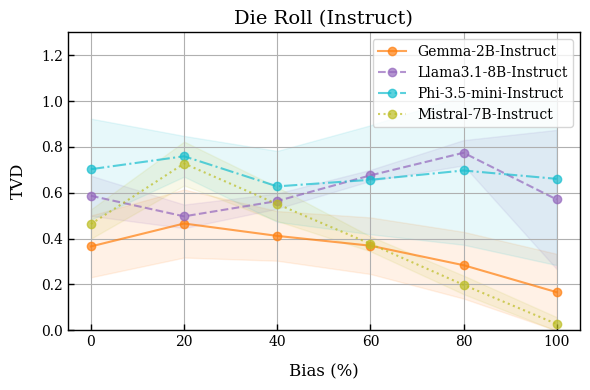

In [26]:
# Plot non-instruct models
plt.clf()
plt.figure()
linestyles = itertools.cycle(['-o', '--o', '-.o', ':o', '-s', '--s', '-.s', ':s', '-^', '--^', '-.^', ':^'])
for i, (model_name, values) in enumerate(sorted(data.items())):
    if values[0][1]:
        color = plt.cm.tab10(i)
        if 'MicroLlama' in model_name:
            continue

        plt.plot([x[0] for x in values], [x[2] for x in values], next(linestyles), label=model_map[model_name],  alpha=0.7, color=model_color_map[model_name])
        plt.fill_between([x[0] for x in values], [x[2] - x[3] for x in values], [x[2] + x[3] for x in values], alpha=0.1, color=model_color_map[model_name])

plt.grid()
plt.title('Die Roll (Instruct)')
plt.xlabel('Bias (%)')
plt.ylabel('TVD')
plt.ylim(0,1.3)
plt.tight_layout()
plt.legend(loc='upper right')
plt.savefig('die_roll_instruct.pdf', bbox_inches='tight')

<Figure size 600x400 with 0 Axes>

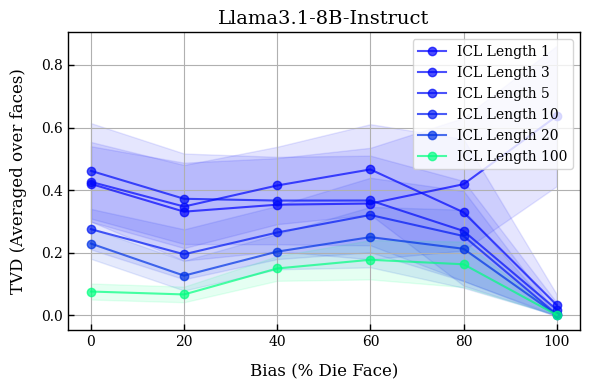

<Figure size 600x400 with 0 Axes>

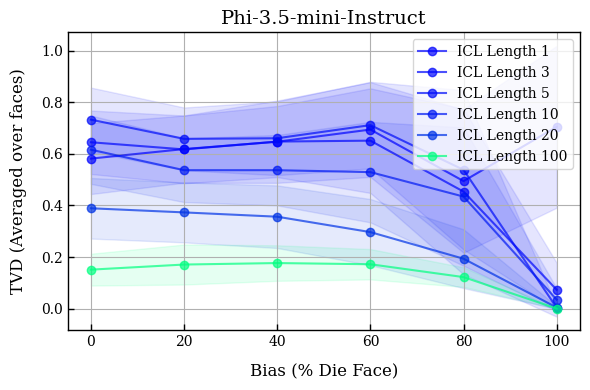

<Figure size 600x400 with 0 Axes>

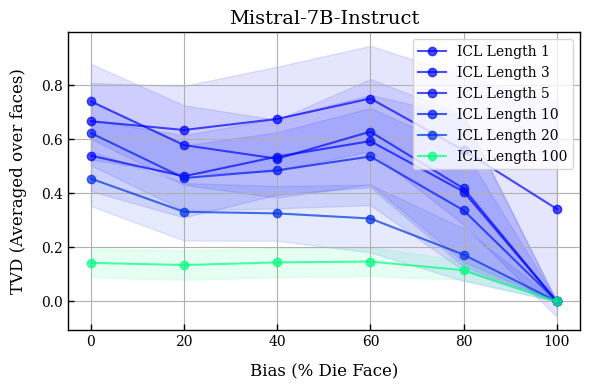

<Figure size 600x400 with 0 Axes>

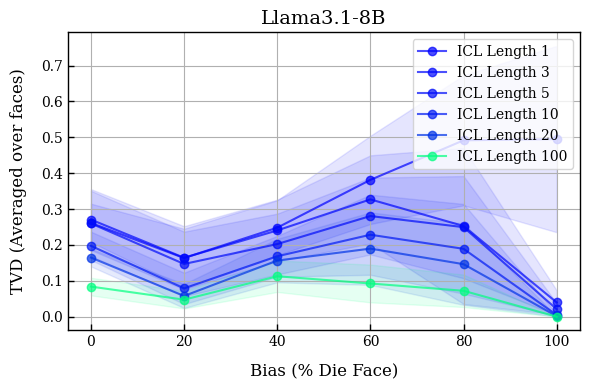

<Figure size 600x400 with 0 Axes>

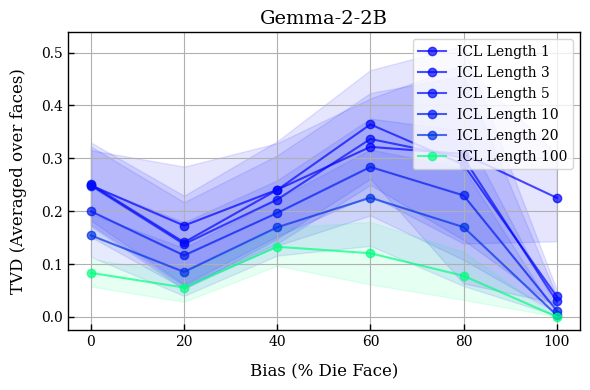

<Figure size 600x400 with 0 Axes>

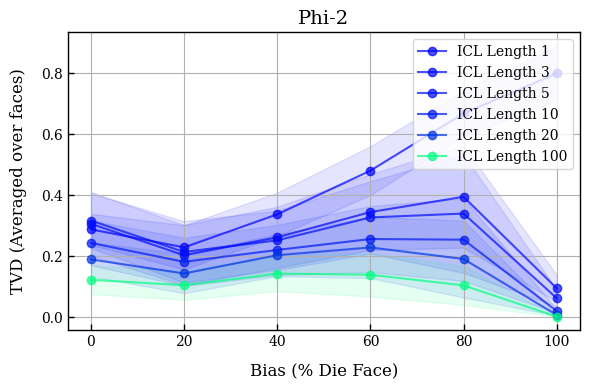

<Figure size 600x400 with 0 Axes>

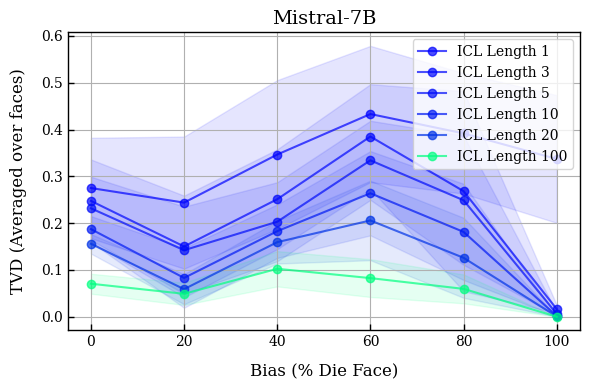

In [10]:
import os
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

# Models to iterate over
models = ['meta-llama/Llama-3.1-8B-Instruct', 'microsoft/Phi-3.5-mini-instruct', 'mistralai/Mistral-7B-Instruct-v0.3', 'meta-llama/Llama-3.1-8B', 'google/gemma-2-2b', 'microsoft/phi-2', 'mistralai/Mistral-7B-v0.3']

# Directory structure template for die rolls
base_dir = '/home/davidchan/Repos/random_needles/exps/contextual/die_roll_icl_v2/icl_{icl_length}/bias_{face}_{bias}/{model_name}/stats.pkl'

# Iterate over each model
for model in models:
    model_name = model.replace("/", "_")  # Adjust the model name for filenames
    data = defaultdict(list)

    # Iterate over ICL lengths and biases
    for icl_length in (1, 3, 5, 10, 20, 100):
        for bias in (0, 20, 40, 60, 80, 100):
            # Initialize list to collect TVD values across die sides
            die_sides = []
            for face in range(1, 7):
                icl_file = base_dir.format(icl_length=icl_length, bias=bias, face=face, model_name=model_name)

                if not os.path.exists(icl_file):
                    continue  # Skip missing files

                with open(icl_file, 'rb') as f:
                    icl_data = pickle.load(f)

                # Use the provided key-matching logic to extract TVD for the given bias
                try:
                    for key in icl_data['averaged_stats']['biased_point']:
                        if f'{bias}%' not in key:
                            continue

                        # Collect TVD mean and standard deviation for this die side
                        die_sides.append((
                            icl_data['averaged_stats']['biased_point'][key]['tvd']['mean'],
                            icl_data['averaged_stats']['biased_point'][key]['tvd']['std']
                        ))

                except KeyError:
                    print(f"Missing data or incorrect format in {icl_file}")
                    continue

            if die_sides:
                # Average TVD across die sides for the given bias
                mean_tvd = np.mean([x[0] for x in die_sides])
                std_tvd = np.mean([x[1] for x in die_sides])  # Averaging standard deviations
                data[icl_length].append((bias, mean_tvd, std_tvd))

    # Plot the results for this model
    plt.clf()
    plt.figure()

    # Plot each ICL length
    for icl_length, values in data.items():
        plt.plot(
            [x[0] for x in values],  # Bias percentages
            [x[1] for x in values],  # Mean TVD values
            '-o', label=f'ICL Length {icl_length}', alpha=0.7, color=plt.cm.winter(icl_length / 100)
        )
        plt.fill_between(
            [x[0] for x in values],  # Bias percentages
            [x[1] - x[2] for x in values],  # Mean - std
            [x[1] + x[2] for x in values],  # Mean + std
            alpha=0.1, color=plt.cm.winter(icl_length / 100)
            #
        )

    # Customize the plot
    plt.grid()
    plt.title(model_map[model_name])
    plt.xlabel('Bias (% Die Face)')
    plt.ylabel('TVD (Averaged over faces)')
    plt.tight_layout()
    plt.legend(loc='upper right')

    # Save the plot as a PDF
    plt.savefig(f'die_roll_icl/{model_name}_die_roll_icl_tvd.pdf', bbox_inches='tight')
    plt.show()
